# 2026 Land-Doig MIP Competition Tutorial: Local Search on GPU

Christian Tjandraatmadja (ctjandra@google.com) and the 2026 Land-Doig MIP
Competition Committee

*Last updated: Dec 17, 2025*

--------------------------------------------------------------------------------

# Part 2: A GPU implementation of feasibility jump via Numba

This tutorial continues from Part 1, which can be found in the [MIP competition website](https://www.mixedinteger.org/2026/competition). If you have not looked at it, please start from there.

In Part 2, we will write a GPU implementation of feasibility jump, using [Numba](https://numba.pydata.org/).

Numba is a just-in-time (JIT) compiler that can take Python code and compile into GPU code. In particular, Numba supports writing explicit CUDA kernels using Python code, which will be useful as not all code from Part 1 can be easily vectorized -- particularly computing deltas and scores for columns with different numbers of nonzeros.

Make sure that you are running a GPU runtime with the cell below.

In [ ]:
# This shows GPU stats to ensure that a GPU is available in the Colab runtime.
# If you get an error here, then you likely need to switch your runtime to GPU.
!nvidia-smi

from numba import cuda
assert cuda.is_available()

# Initial setup and utility functions

These hidden cells need to be run first for the tutorial. These same cells appear on all parts. They contain imports and some
utility functions that will be useful later in the tutorial.
This is not too important for the tutorial itself and you can run this cell
without looking, though you may want to take a quick glance at the imports that
we will be using.

This includes the `IPInstance` data structure that was more explicit in Part 1, and the utility functions for feasibility jump.

In [2]:
import dataclasses
from typing import NamedTuple
import math

# Numba imports.
# Tip: If you need to debug Numba, uncomment below to use the CUDA simulator.
# https://numba.pydata.org/numba-doc/dev/cuda/simulator.html
# import os
# os.environ['NUMBA_ENABLE_CUDASIM'] = '1'
import numba
from numba import cuda

# JAX imports.
import jax
from jax.experimental import sparse
import jax.numpy as jnp

import matplotlib.pyplot as plt
import numpy as np
import scipy  # For sparse matrices.

In [3]:
@dataclasses.dataclass
class IPInstance:
  """Data structure to store a (pure) Integer Programming instance.

    minimize c^T x
      Ax <= b
      var_lb <= x <= var_ub
            x integer

  All vectors are stored as dense numpy vectors. The matrix A is stored as
  a sparse matrix in compressed sparse row (CSR) format.
  """

  c: np.ndarray
  A: scipy.sparse.csr_matrix
  b: np.ndarray
  var_lb: np.ndarray
  var_ub: np.ndarray

SIMPLE_IP = IPInstance(
    c=np.array([-1, -1]),
    A=scipy.sparse.csr_matrix(np.array([[-1, -2.5], [1, 2.5], [-3, 1], [1, 0]])),
    b=np.array([-3.5, 12, 0, 2.5]),
    var_lb=np.array([0, 0]),
    var_ub=np.array([3, 5]),
)

In [4]:
def initialize_solution(instance: IPInstance) -> np.ndarray:
  """Return the zero point, projected to variable bounds if outside them."""
  init_x = np.zeros(instance.A.shape[1])
  init_x = np.maximum(init_x, instance.var_lb)
  init_x = np.minimum(init_x, instance.var_ub)
  return init_x


def extend_A_b_with_objective_constraint(
    instance: IPInstance
) -> tuple[scipy.sparse.spmatrix, np.ndarray]:
  """Returns A and b with an additional row for objective constraint."""
  c_sparse = scipy.sparse.csr_matrix(instance.c)
  A_ext = scipy.sparse.vstack((instance.A, c_sparse), format='csr')
  b_ext = np.append(instance.b, np.inf)
  return A_ext, b_ext


# The right-hand side of objective constraint will be the best primal bound,
# minus this value. This emulates a strict inequality, though in this case it
# does not need to be necessarily small if we want to incentivize larger jumps.
OBJECTIVE_PUSH_VALUE = 1e-3

# Absolute tolerance for feasibility.
FEASIBILITY_TOLERANCE = 1e-6

# Numba implementation

We will implement feasibility jump using CUDA kernels. A kernel is simply a function that runs on GPU, as described in this [programming model for GPUs page](https://docs.nvidia.com/cuda/cuda-programming-guide/01-introduction/programming-model.html) (recommended reading). We essentially define the same code for every GPU thread, and a GPU executes them all in parallel.

We assume that the reader has gone through Part 1 and is familiar with the functions that we want to write, so we will jump into the code.

**Sparse data structures:** We preface that we will continue using the sparse CSC format as in Part 1, except that we will work with explicit arrays, i.e. data, row indices, and column index pointers (for a refresher, see  [here](https://docs.nvidia.com/cuda/cusparse/#matrix-formats)).

We will start with a kernel for `compute_critical_deltas`, which we need to decorate with `@cuda.jit` to indicate that it will be JIT compiled. In Part 1, with vectorized computation, we computed critical deltas for all columns at the same time. Here, we actually dive down to a much smaller unit of execution and compute critical deltas for a single nonzero, each of which will be executed in a different thread.

The important part here is that we need to identify which thread we are running. This is collected with `cuda.grid(1)`, which will have a different value for each thread, and we use that as index for our sparse data array of nonzeros. Later on, we will specify how many threads we want. This is done in number of blocks which may exceed the data size, so we need to account for indices above our data size.

Note that we can effectively use Python code somewhat freely, which is perhaps simpler than the vectorized version, but they will not be parallelized (e.g. if we write a for loop, it will still be sequential within each thread).

In [5]:
# Define number of threads per block. We will use this later for defining how
# many threads each kernel should be run on.
THREADS_PER_BLOCK = 256

@cuda.jit
def compute_critical_deltas_gpu_numba(
    A_data, A_indices, residuals, critical_deltas_data
):
  """Compute critical deltas for each nonzero A_ij.

    d_ij = floor(r_i / A_ij)  if A_ij > 0
           ceil(r_i / A_ij)   if A_ij < 0

  Each thread will perform computation for a single nonzero.
  """
  # Get the current thread as index. This is what will vary between threads.
  idx = cuda.grid(1)
  # This check is needed as we should not perform computation beyond data size.
  # Some threads may fall outside since they are run in blocks.
  if idx >= A_data.size:
    return

  val = A_data[idx]
  row_idx = A_indices[idx]
  res = residuals[row_idx]
  # We assume that A_data has no zeros, but do this for safety.
  if val == 0:
    critical_deltas_data[idx] = 0.0
    return
  # Residual can be infinity from an unconstrained objective constraint.
  if math.isinf(res):
    critical_deltas_data[idx] = math.inf
    return
  ratio = res / val
  if val > 0:
    critical_deltas_data[idx] = math.floor(ratio)
  else:
    critical_deltas_data[idx] = math.ceil(ratio)

We now write `compute_violations` and `compute_best_deltas_and_scores`. Recall that to compute deltas and scores, we perform computation over three dimensions:

1. for all variables, compute score;
2. to compute score, we compute violation values for all critical deltas + bounds + zero;
3. to compute violation value, we sum up terms for all rows with nonzero coefficients.

Recall that 2 and 3 could technically be "merged", since we can sort critical deltas to find the minimum of the convex piecewise linear function using a linear scan, as proposed in the original paper. Although we have not verified this, a GPU implementation that emulates that is likely more efficient: asymptotic time improvements are more beneficial than parallelization improvements for large problems. However, to keep this tutorial simpler, we leave that approach outside our scope.

To illustrate two parallelization approaches, we write two versions:

* **column**: Parallelize only by column. That is, parallelize item 1, and leave items 2 and 3 sequential.
* **column and deltas**: Parallelize by column, and when computing score, parallelize by critical deltas + bounds + zero. That is, parallelize items 1 and 2, and leave item 3 sequential.

When we make the choice of parallelizing by column, we may run into a common obstacle of **load imbalance**. If we have a sparse column and a dense column, we will be bottlenecked by the one with many. Resolving this can be specific to each situation: for example, we can categorize columns with few and many nonzeros and parallelize them in different ways. We do something simple along these lines in the JAX version in Part 3, but we will generally leave this outside the scope of this tutorial.

We start with the column-only parallelization (which we call `v1` in the code). This works similarly to the previous function: we write code that processes each column, and within each function, we use (sequential) for loops. For both cases, we will use the exact same `compute_violation` function, as we are not planning on parallelizing it.

In [6]:
# `device=True` makes this a device function, which can only be called from
# another kernel. We call this in `compute_best_deltas_and_scores_gpu_numba`.
@cuda.jit(device=True)
def compute_violation_gpu_numba(
    delta,
    col_start_ptr,
    col_end_ptr,
    row_indices,
    A_data,
    critical_deltas_data,
    weights,
):
  """Computes violation for a specific delta value, given a specific column."""
  # Violation function:
  #   sum_i max(0, sign(A[i][j]) * w[i] * (delta - cd[i][j]))
  total_violation = 0.0
  # Note that this for loop is performed *sequentially* within a GPU thread.
  # `col_start_ptr` and `col_end_ptr` come from CSC and indicate where the
  # column starts and ends.
  for i in range(col_start_ptr, col_end_ptr):
    weight = weights[row_indices[i]]
    A_val = A_data[i]
    cd_val = critical_deltas_data[i]
    if cd_val == math.inf:
      continue  # We use inf for an unconstrained objective constraint.
    A_sign = 1.0 if A_val > 0 else (-1.0 if A_val < 0 else 0.0)
    term = A_sign * weight * (delta - cd_val)
    total_violation += max(0, term)
  return total_violation


@cuda.jit
def compute_best_deltas_and_scores_gpu_numba_v1(
    col_indptr,
    row_indices,
    A_data,
    critical_deltas_data,
    weights,
    delta_lb,
    delta_ub,
    out_best_deltas,
    out_scores,
):
  # Each thread does computation for a column.
  col = cuda.grid(1)
  if col >= len(col_indptr) - 1:
    return

  # Get pointers for the start and end of column col. Column pointers are the
  # same for A_data and critical_deltas_data, since they are aligned.
  col_start_ptr = col_indptr[col]
  col_end_ptr = col_indptr[col + 1]

  # Ideally we would preprocess out empty columns, but return zero just in case.
  if col_start_ptr == col_end_ptr:
    out_best_deltas[col] = 0.0
    out_scores[col] = 0.0
    return

  # We want to compute violation for all critical deltas, plus delta_lb,
  # delta_ub, and zero. We start with zero, particularly since we need it store
  # its value separately anyway to compute the score.
  viol_zero = compute_violation_gpu_numba(
      0.0,
      col_start_ptr,
      col_end_ptr,
      row_indices,
      A_data,
      critical_deltas_data,
      weights,
  )

  min_viol = viol_zero
  best_delta = 0.0

  lb = delta_lb[col]
  ub = delta_ub[col]

  # Compute violation for all critical deltas, plus delta_lb, delta_ub.
  num_col_entries = col_end_ptr - col_start_ptr
  for k in range(num_col_entries + 2):
    if k == num_col_entries:
      candidate_delta = lb
    elif k == num_col_entries + 1:
      candidate_delta = ub
    else:
      candidate_delta = critical_deltas_data[col_start_ptr + k]
      if candidate_delta < lb or candidate_delta > ub:
        continue

    # Compute violation.
    current_viol = compute_violation_gpu_numba(
        candidate_delta,
        col_start_ptr,
        col_end_ptr,
        row_indices,
        A_data,
        critical_deltas_data,
        weights,
    )

    # Store delta with lowest violation.
    if (current_viol < min_viol) or (
        current_viol == min_viol and abs(candidate_delta) < abs(best_delta)
    ):
      min_viol = current_viol
      best_delta = candidate_delta

  # Store the delta for the lowest violation, and the score of this column.
  out_best_deltas[col] = best_delta
  out_scores[col] = viol_zero - min_viol

We now parallelize both by column and by candidate deltas (critical deltas + bounds + zero). Instead of parallelizing directly by thread, we show an example that parallelizes this in a different way: **each block will handle a column, and each thread within that block will handle a candidate delta**. This makes it easier to then collect the best delta, as we can use a block's shared memory. This memory is very fast as it is on-chip, but of course we need to be careful with race conditions.

Note that because we assign an entire column to a block, this may underutilize the GPU if we have fewer nonzeros in a column that the number of threads in a block (set to 256 in this tutorial). This is perhaps not ideal in practice since many MIP instances may be sparser than that, but this is an interesting example anyway for purposes of a tutorial.

We still use the function `compute_violation_gpu_numba` above, which serially iterates through nonzeros in a column. We also define a `reduce_min` function below to collect the minimum violation and best delta across threads.

In [7]:
# This auxiliary function will help us find the minimum violation and delta
# across different threads. It implements a typical tree-based parallel
# reduction to find the minimum value, see e.g.
# https://cs.wmich.edu/gupta/teaching/cs5260/5260Sp15web/lectureNotes/ece408-lecture11-reduction-tree-2011.pdf
@cuda.jit(device=True)
def block_reduce_min(tid, val, delta_val, s_val, s_delta, block_size):
  """Finds minimum `val` and `delta_val` across threads in block."""
  s_val[tid] = val
  s_delta[tid] = delta_val
  cuda.syncthreads()  # Ensures that all threads have written to shared memory.

  stride = block_size // 2
  while stride > 0:
    if tid < stride:  # For each pair, run only on the leftmost node.
      # Compare values with its pair, and store the smallest value.
      if s_val[tid + stride] < s_val[tid]:
        s_val[tid] = s_val[tid + stride]
        s_delta[tid] = s_delta[tid + stride]
      elif s_val[tid + stride] == s_val[tid]:
        # Tie-break by absolute delta.
        if abs(s_delta[tid + stride]) < abs(s_delta[tid]):
          s_delta[tid] = s_delta[tid + stride]
    cuda.syncthreads()  # Wait for each round to finish before next step.
    stride = stride // 2
  # The result ends up in s_val[0] and s_delta[0], since we keep storing the
  # minimum on the leftmost node.


@cuda.jit
def compute_best_deltas_and_scores_gpu_numba_v2(
    col_indptr,
    row_indices,
    A_data,
    critical_deltas_data,
    weights,
    delta_lb,
    delta_ub,
    out_best_deltas,
    out_scores,
):
  # Since we are parallelizing at the block level, we take both block and
  # thread indices instead of using the convenience function `cuda.grid`
  # (which is essentially threadIdx.x + blockIdx.x * blockDim.x).
  # We will do one column per block, and one delta candidate per thread.
  col = cuda.blockIdx.x
  tid = cuda.threadIdx.x
  block_size = cuda.blockDim.x
  if col >= len(col_indptr) - 1:
    return

  # Allocate shared memory. As each column parallelizes over all threads in a
  # block, this should be exactly the number of threads in a block.
  s_min_viol = cuda.shared.array(THREADS_PER_BLOCK, dtype=numba.float32)
  s_best_delta = cuda.shared.array(THREADS_PER_BLOCK, dtype=numba.float32)

  col_start_ptr = col_indptr[col]
  col_end_ptr = col_indptr[col + 1]

  # Handle empty columns.
  if col_start_ptr == col_end_ptr:
    if tid == 0:
      out_best_deltas[col] = 0.0
      out_scores[col] = 0.0
    return

  # Initialize local best. Each thread tracks its own local minimum. Note that
  # we need to ensure that this is inf because some threads may do nothing but
  # initialization if we have fewer nonzeros than number of threads in a block.
  local_min_viol = math.inf
  local_best_delta = 0.0

  lb = delta_lb[col]
  ub = delta_ub[col]
  num_col_entries = col_end_ptr - col_start_ptr
  viol_zero = 0.0  # Stores violation for delta zero, only tid 0 uses it.

  # The candidate deltas are zero, critical_deltas, lb, ub.
  total_candidates = num_col_entries + 3

  # We may have more delta candidates than the number of threads in a block.
  # Therefore, we still process groups of candidates sequentially, so we start
  # at the thread index, and increment by block size until all candidates are
  # covered. This is called a grid-stride loop:
  # https://developer.nvidia.com/blog/cuda-pro-tip-write-flexible-kernels-grid-stride-loops/
  for k in range(tid, total_candidates, block_size):

    # Determine which delta this k corresponds to. We actually have k = 0 be
    # the value for candidate delta zero, since we need the writer thread (0)
    # to compute that so that we can use it to compute the score below.
    candidate_delta = 0.0
    if k == 0:
      candidate_delta = 0.0
    elif k <= num_col_entries:
      candidate_delta = critical_deltas_data[col_start_ptr + (k - 1)]
    elif k == num_col_entries + 1:
      candidate_delta = lb
    elif k == num_col_entries + 2:
      candidate_delta = ub

    if candidate_delta < lb or candidate_delta > ub:
      continue

    # Compute violation. The loop inside this function is still serial.
    current_viol = compute_violation_gpu_numba(
        candidate_delta,
        col_start_ptr,
        col_end_ptr,
        row_indices,
        A_data,
        critical_deltas_data,
        weights,
    )

    if candidate_delta == 0.0:
      viol_zero = current_viol

    # Update local best.
    if (current_viol < local_min_viol) or (
        current_viol == local_min_viol
        and abs(candidate_delta) < abs(local_best_delta)
    ):
      local_min_viol = current_viol
      local_best_delta = candidate_delta

  # With the best values for each thread, we need to find the global minimum
  # across threads of the block. We use shared memory for this.
  block_reduce_min(
      tid,
      local_min_viol,
      local_best_delta,
      s_min_viol,
      s_best_delta,
      block_size,
  )

  # Write result. Only one thread needs to do the writing.
  if tid == 0:
    final_min_viol = s_min_viol[0]
    final_best_delta = s_best_delta[0]

    out_best_deltas[col] = final_best_delta
    # Note that `viol_zero` is local since we guarantee that tid 0 computes it.
    out_scores[col] = viol_zero - final_min_viol

Finally, we write a few more GPU kernels that were previously inline in Part 1. In this implementation, any computation involving an array of non-trivial size will be on device (GPU) to avoid moving them back and forth between CPU-GPU. The kernels below should be generally self-explanatory.

In [8]:
@cuda.jit
def update_residuals_gpu_numba(
    residuals, A_data, A_row_indices, col_start_ptr, col_end_ptr, delta
):
  """Updates residuals: r_new = r_old - A_col * delta."""
  # Each thread does computation for a nonzero entry in the selected column.
  idx = cuda.grid(1)
  num_col_entries = col_end_ptr - col_start_ptr
  if idx >= num_col_entries:
    return
  col = col_start_ptr + idx
  row_idx = A_row_indices[col]
  # We assume unique row indices per column, otherwise we need to update this
  # with an atomic operation. In addition, as previously noted, in practice one
  # might need to deal with numerical imprecisions from iterative updates.
  residuals[row_idx] -= A_data[col] * delta


@cuda.jit
def update_weights_and_check_feasibility_gpu_numba(
    weights, residuals, out_feasibility_flag, feas_tol
):
  """Updates weights based on violations and checks feasibility."""
  # Each thread does computation for a constraint (row).
  row_idx = cuda.grid(1)
  if row_idx >= residuals.size:
    return
  # If b - Ax < -feas_tol, the constraint is violated. Update weight by one as
  # per our simple weight update mechanism.
  if residuals[row_idx] < -feas_tol:
    weights[row_idx] += 1.0
    # Mark solution as infeasible. Note that any violation causes infeasibility,
    # so race conditions are not relevant here.
    out_feasibility_flag[0] = 0


@cuda.jit
def compute_delta_bounds_gpu_numba(
    var_lb, var_ub, x, out_delta_lb, out_delta_ub
):
  """Computes delta_lb and delta_ub on the GPU."""
  # Each thread does computation for a variable (column). This could be fused
  # with the violation/score function, but we keep it separate for clarity.
  i = cuda.grid(1)
  if i >= x.size:
    return
  out_delta_lb[i] = var_lb[i] - x[i]
  out_delta_ub[i] = var_ub[i] - x[i]

Finally, we write the main loop. Note that the function always starts at CPU, but any kernel written above will run on GPU. We include an argument to decide which of the two parallelization schemes to use.

It is ideal to avoid moving too much data around between CPU and GPU, as the communication cost can be expensive. In this case, we keep all the heavy data on GPU. We still keep some data on CPU, in particular a copy of the solution. Since we only update one variable at a time, we pass very little data to keep the CPU and GPU copies updated.

In [9]:
def run_feasibility_jump_gpu_numba(
    instance: IPInstance,
    init_x: np.ndarray,
    max_num_steps: int,
    use_v2_parallelization: bool = False,
    print_progress: bool = True,
) -> np.ndarray:
  # Important: `print_progress` causes data to be moved from GPU to CPU at
  # every iteration, so it should only be True for debugging.

  # Perform some initialization on host (CPU).
  x_host = init_x.astype(np.float64)
  obj_val = np.dot(instance.c, x_host)
  best_feasible_obj_val = np.inf
  best_x = x_host.copy()

  # We assume that there will be no zero entries in the sparse representation.
  # This depends on construction, as a user might manually add zero entries.
  assert np.all(
      instance.A.data != 0
  ), 'Ensure that sparse entries in A do not include zero.'

  # Initialize weights to be all ones. Note that this includes the constraint
  # on the objective.
  weights = np.ones(instance.A.shape[0] + 1, dtype=np.float64)

  # Extend A and b by adding a constraint for the objective function. At first
  # we do not enforce any value for the objective.
  A_ext, b_ext = extend_A_b_with_objective_constraint(instance)

  # Initialize residuals.
  residuals_host = b_ext - A_ext @ x_host

  # Convert the matrix A to CSC format, which will be more convenient and
  # efficient as our computation is typically column-wise.
  A_ext = A_ext.tocsc()

  # Move all the relevant data to GPU. These will live and be updated on the
  # GPU, otherwise it would be too expensive to move data back and forth.

  # Static data throughout the loop.
  d_A_data = cuda.to_device(A_ext.data)
  d_A_indices = cuda.to_device(A_ext.indices)
  d_A_indptr = cuda.to_device(A_ext.indptr)
  d_weights = cuda.to_device(weights)
  d_var_lb = cuda.to_device(instance.var_lb)
  d_var_ub = cuda.to_device(instance.var_ub)

  # Variable data.
  d_x = cuda.to_device(x_host)
  d_residuals = cuda.to_device(residuals_host)

  # Intermediate results.
  num_nonzeros = A_ext.data.size
  num_cols = A_ext.shape[1]
  num_rows = A_ext.shape[0]
  d_critical_deltas = cuda.device_array(num_nonzeros, dtype=np.float64)
  d_out_best_deltas = cuda.device_array(num_cols, dtype=np.float64)
  d_out_scores = cuda.device_array(num_cols, dtype=np.float64)
  d_delta_lb = cuda.device_array(num_cols, dtype=np.float64)
  d_delta_ub = cuda.device_array(num_cols, dtype=np.float64)
  d_feasibility_flag = cuda.device_array(1, dtype=np.int32)

  # Kernel configuration.
  # `THREADS_PER_BLOCK` defines the number of threads that will be run together
  # in the same stream. This must be a multiple of the size of a warp, which is
  # the size of the smallest unit of execution (typically 32).
  threads_per_block = THREADS_PER_BLOCK
  # Define the number of blocks to run, which depends on how many threads we
  # want to launch. For example, if we are using a thread per nonzero, we need
  # at least `num_nonzeros` threads, thus choose `num_blocks_nnz` so that
  # `num_blocks_nnz * threads_per_block` is at least `num_nonzeros`.
  num_blocks_nnz = (num_nonzeros + threads_per_block - 1) // threads_per_block
  num_blocks_cols = (num_cols + threads_per_block - 1) // threads_per_block
  num_blocks_rows = (num_rows + threads_per_block - 1) // threads_per_block

  if print_progress:
    print('Starting feasibility jump from initial solution:')
    print(f'  {init_x}, obj_val = {obj_val}')
    print()

  # Select function based on parallelization type.
  if use_v2_parallelization:
    compute_best_deltas_and_scores = compute_best_deltas_and_scores_gpu_numba_v2
    # We assign one block per column in this parallelization scheme.
    num_blocks_scoring = num_cols
  else:
    compute_best_deltas_and_scores = compute_best_deltas_and_scores_gpu_numba_v1
    num_blocks_scoring = num_blocks_cols

  # Main loop for feasibility jump. Given that this for loop is sequential, it
  # is run on CPU. Note however that we have already moved the heavy data to GPU
  # at this point, and CPU-GPU communication is kept small.
  for i in range(max_num_steps):
    # These updates are the same as the CPU implementation. For simplicity, we
    # do some of the lighter computation on CPU. Potentially, we could move more
    # computation to the GPU, but this is not a bottleneck.
    pushed_obj_rhs = best_feasible_obj_val - OBJECTIVE_PUSH_VALUE
    curr_obj_val = np.dot(instance.c, x_host)
    new_obj_res = pushed_obj_rhs - curr_obj_val
    # Copy the residual for the objective constraint to GPU.
    cuda.to_device(np.array([new_obj_res]), to=d_residuals[num_rows - 1 :])

    # Compute critical deltas on GPU. In brackets, we declare thread hierarchy:
    # execute `num_blocks_nnz` blocks, each with `threads_per_block` threads.
    compute_critical_deltas_gpu_numba[num_blocks_nnz, threads_per_block](
        d_A_data, d_A_indices, d_residuals, d_critical_deltas
    )

    # Update delta bounds on GPU.
    compute_delta_bounds_gpu_numba[num_blocks_cols, threads_per_block](
        d_var_lb, d_var_ub, d_x, d_delta_lb, d_delta_ub
    )

    # Compute violations, scores, and corresponding deltas on GPU.
    compute_best_deltas_and_scores[
        num_blocks_scoring, threads_per_block
    ](
        d_A_indptr,
        d_A_indices,
        d_A_data,
        d_critical_deltas,
        d_weights,
        d_delta_lb,
        d_delta_ub,
        d_out_best_deltas,
        d_out_scores,
    )

    # Select the variable with the highest score.
    selected_var = np.argmax(d_out_scores)

    # Take best delta and update x in both CPU and GPU, copying scalars around.
    # Importantly, we do not copy all x as we only update one variable per step.
    # If we did, it could be a reason to move more computation to GPU.
    best_delta = d_out_best_deltas[selected_var]
    current_val_x = d_x[selected_var]
    d_x[selected_var] = current_val_x + best_delta  # Update x on device.
    x_host[selected_var] += best_delta  # Update x on host.
    new_obj_val = np.dot(instance.c, x_host)

    # Update residuals vector. We collect data for the relevant column first.
    c_start = A_ext.indptr[selected_var]
    c_end = A_ext.indptr[selected_var + 1]
    col_nnz = c_end - c_start
    if col_nnz > 0:
      blocks_res = (col_nnz + threads_per_block - 1) // threads_per_block
      update_residuals_gpu_numba[blocks_res, threads_per_block](
          d_residuals, d_A_data, d_A_indices, c_start, c_end, best_delta
      )

    # Update weights, checking feasibility along the way.
    d_feasibility_flag[0] = 1
    update_weights_and_check_feasibility_gpu_numba[
        num_blocks_rows, threads_per_block
    ](d_weights, d_residuals, d_feasibility_flag, FEASIBILITY_TOLERANCE)
    is_feasible = d_feasibility_flag[0] == 1

    # If the current solution is feasible, store it.
    if is_feasible and new_obj_val < best_feasible_obj_val:
      best_feasible_obj_val = new_obj_val
      best_x = x_host.copy()

    # Print progress. Note that this step requires copying weights from device.
    if print_progress:
      print(f'=== Iteration {i+1} ===')
      if best_delta != 0:
        w_host = d_weights.copy_to_host()
        print(f'Update: x[{selected_var}] = x[{selected_var}] + {best_delta}')
        print(f'  New solution: {x_host}, obj_val = {new_obj_val}')
        print(f'  New weights: {w_host}')
      else:
        print('No variable update. Cannot continue. Done.')
        break
      print(
          f'  Best feasible solution: {best_x}, obj_val ='
          f' {best_feasible_obj_val}'
      )
      print()

  return best_x

# Run heuristic for simple example

In [10]:
# Run feasibility jump for simple instance with first parallelization scheme.
# Note: We may get performance warnings from Numba here because this is a very
# small instance. In particular, we only have 5 nonzeros in A in SIMPLE_IP, but
# our block size is 256, so we get a warning from using a single block.
init_x = initialize_solution(SIMPLE_IP)
run_feasibility_jump_gpu_numba(SIMPLE_IP, init_x, max_num_steps=10, use_v2_parallelization=False)

Starting feasibility jump from initial solution:
  [0. 0.], obj_val = 0.0



/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 

=== Iteration 1 ===
Update: x[0] = x[0] + 2.0
  New solution: [2. 0.], obj_val = -2.0
  New weights: [2. 1. 1. 1. 1.]
  Best feasible solution: [0. 0.], obj_val = inf

=== Iteration 2 ===
Update: x[1] = x[1] + 1.0
  New solution: [2. 1.], obj_val = -3.0
  New weights: [2. 1. 1. 1. 1.]
  Best feasible solution: [2. 1.], obj_val = -3.0

=== Iteration 3 ===
Update: x[1] = x[1] + 1.0
  New solution: [2. 2.], obj_val = -4.0
  New weights: [2. 1. 1. 1. 1.]
  Best feasible solution: [2. 2.], obj_val = -4.0

=== Iteration 4 ===
Update: x[1] = x[1] + 1.0
  New solution: [2. 3.], obj_val = -5.0
  New weights: [2. 1. 1. 1. 1.]
  Best feasible solution: [2. 3.], obj_val = -5.0

=== Iteration 5 ===
Update: x[1] = x[1] + 1.0
  New solution: [2. 4.], obj_val = -6.0
  New weights: [2. 1. 1. 1. 1.]
  Best feasible solution: [2. 4.], obj_val = -6.0

=== Iteration 6 ===
No variable update. Cannot continue. Done.


/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


array([2., 4.])

In [11]:
# Run feasibility jump for simple instance with second parallelization scheme.
# For this small instance, we underutilize the GPU even more than the first
# parallelization: we reserve a block with 256 threads per column (512 total for
# two columns), but we only use 2-3 threads per column.
init_x = initialize_solution(SIMPLE_IP)
run_feasibility_jump_gpu_numba(SIMPLE_IP, init_x, max_num_steps=10, use_v2_parallelization=True)

Starting feasibility jump from initial solution:
  [0. 0.], obj_val = 0.0



/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 2 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


=== Iteration 1 ===
Update: x[0] = x[0] + 2.0
  New solution: [2. 0.], obj_val = -2.0
  New weights: [2. 1. 1. 1. 1.]
  Best feasible solution: [0. 0.], obj_val = inf

=== Iteration 2 ===
Update: x[1] = x[1] + 1.0
  New solution: [2. 1.], obj_val = -3.0
  New weights: [2. 1. 1. 1. 1.]
  Best feasible solution: [2. 1.], obj_val = -3.0

=== Iteration 3 ===
Update: x[1] = x[1] + 1.0
  New solution: [2. 2.], obj_val = -4.0
  New weights: [2. 1. 1. 1. 1.]
  Best feasible solution: [2. 2.], obj_val = -4.0

=== Iteration 4 ===
Update: x[1] = x[1] + 1.0
  New solution: [2. 3.], obj_val = -5.0
  New weights: [2. 1. 1. 1. 1.]
  Best feasible solution: [2. 3.], obj_val = -5.0

=== Iteration 5 ===
Update: x[1] = x[1] + 1.0
  New solution: [2. 4.], obj_val = -6.0
  New weights: [2. 1. 1. 1. 1.]
  Best feasible solution: [2. 4.], obj_val = -6.0

=== Iteration 6 ===
No variable update. Cannot continue. Done.


/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


array([2., 4.])

# Benchmarking setup

We use the same cutting stock instances as in Part 1. Furthermore, we copy the numpy CPU implementation in the following hidden cell for a comparison.

In [12]:
def generate_cutting_stock_instance(
    num_items: int,
    num_extra_patterns: int,
    max_item_types_per_pattern: int = 8,
    max_bin_width: int = 400,
    seed: int = 1234,
) -> IPInstance:
  """Generates a random instance for a simple cutting stock problem.

  We consider a cutting stock problem where the patterns are fixed. For a
  description, see https://en.wikipedia.org/wiki/Cutting_stock_problem, except
  that we generate a random set of patterns to choose from.

    min sum(x)
        Ax >= b
         x >= 0, integer

  where variables x_j indicates that we use pattern j x_j times.

  To emulate some sparsity, we limit the number of item types in each pattern.
  This implies that the number of nonzeros per column is bounded by
  `max_item_types_per_pattern`.

  Args:
    num_items: Number of items in the cutting stock problem, corresponding to
      the number of constraints.
    num_extra_patterns: Number of patterns beyond singleton patterns. The total
      number of variables will be num_items + num_extra_patterns.
    max_item_types_per_pattern: Maximum number of item types in each pattern.
      This bounds the number of nonzeros per column.
    seed: Seed for random number generator.

  Returns:
    An IPInstance corresponding to the generated instance.
  """
  np.random.seed(seed)

  min_item_width = 5
  max_item_width = 20
  min_demand = 5
  max_demand = 40

  # Generate widths and demands for each item.
  item_widths = np.random.randint(
      min_item_width, max_item_width + 1, size=num_items
  )
  item_demands = np.random.randint(min_demand, max_demand, size=num_items)

  # Add singleton patterns, each of which contains one item, for feasibility.
  singleton_patterns = np.eye(num_items, dtype=int)

  extra_patterns = []
  # Add random patterns by randomly adding items until capacity. We restrict to
  # a subset of item types per pattern, limited by `max_item_types_per_pattern`.
  for _ in range(num_extra_patterns):
    allowed_items = np.random.choice(
        num_items,
        size=min(max_item_types_per_pattern, num_items),
        replace=False,
    )
    # Generate a long random stream of items.
    min_width = item_widths[allowed_items].min()
    num_gen_items = int(max_bin_width / max(1, min_width)) + 1
    candidate_stream = np.random.choice(allowed_items, size=num_gen_items)

    # Cut off the stream at `max_bin_width`.
    cumulative_widths = np.cumsum(item_widths[candidate_stream])
    cutoff = np.searchsorted(cumulative_widths, max_bin_width, side='right')

    # Count the items in the array.
    pattern = np.bincount(candidate_stream[:cutoff], minlength=num_items)
    extra_patterns.append(pattern)

  # Shape is (num_vars (i.e. num_patterns), num_items).
  patterns = np.vstack([singleton_patterns, np.array(extra_patterns)])

  num_vars = len(patterns)

  # Construct constraint coefficient matrix A in sparse form.
  col_indices, row_indices = patterns.nonzero()
  data = -patterns[col_indices, row_indices]  # Negate since we use <=.
  A = scipy.sparse.csr_matrix(
      (data, (row_indices, col_indices)),
      shape=(patterns.shape[1], patterns.shape[0])
  )

  # Construct RHS, which are simply item demands (negated due to <=).
  rhs = -item_demands.astype(np.float64)

  # Objective function is to minimize total numbers of patterns used.
  obj_c = np.ones(num_vars, dtype=np.float64)

  # Define variable bounds. We assume problem is bounded.
  var_lb = np.zeros(num_vars, dtype=np.float64)
  var_ub = np.full(num_vars, 100, dtype=np.float64)

  return IPInstance(
      c=obj_c,
      A=A,
      b=rhs,
      var_lb=var_lb,
      var_ub=var_ub,
  )

In [13]:
# This is (mostly) a copy of the Part 1 implementation for comparison purposes.

def compute_critical_deltas_cpu_sparse(
    A: scipy.sparse.csc_matrix, residuals: np.ndarray
) -> scipy.sparse.csc_matrix:
  """Compute critical deltas for each nonzero A_ij.

    d_ij = floor(r_i / A_ij)  if A_ij > 0
           ceil(r_i / A_ij)   if A_ij < 0

  The result is a matrix of the same size as A. In this sparse version, we
  assume that we do not have zero entries in the nonzero data. Note that this
  is not guaranteed as a user can add them manually.
  """
  row_indices = A.indices
  # We make a hard assumption that A.data has no zeros.
  ratio_matrix = residuals[row_indices] / A.data
  critical_delta_data = np.select(
      [A.data > 0, A.data < 0],
      [np.floor(ratio_matrix), np.ceil(ratio_matrix)],
  )
  return scipy.sparse.csc_matrix(
      (critical_delta_data, A.indices, A.indptr), shape=A.shape
  )

def compute_violations_cpu_sparse(
    deltas: np.ndarray,
    A_col: np.ndarray,
    critical_deltas_col: np.ndarray,
    weights_col: np.ndarray,
) -> np.ndarray:
  """Computes the violation function for all `deltas` for a given column."""
  # Note that we do not need to pass the column index here as we are given only
  # the relevant column data directly.
  # Violation function:
  #   sum_i max(0, sign(A_col[i]) * w[i] * (deltas - cd_col[i]))
  terms = (
      np.sign(A_col)[:, None]
      * weights_col[:, None]
      * (deltas[None, :] - critical_deltas_col[:, None])
  )
  all_violations = np.maximum(0, terms)
  return np.sum(all_violations, axis=0)

def compute_best_deltas_and_scores_cpu_sparse(
    A: scipy.sparse.csc_matrix,
    critical_deltas: scipy.sparse.csc_matrix,
    weights: np.ndarray,
    delta_lb: np.ndarray,
    delta_ub: np.ndarray,
) -> tuple[np.ndarray, np.ndarray]:
  """Computes deltas and scores for all variables."""
  _, num_cols = A.shape
  best_deltas = []
  scores = []
  for j in range(num_cols):
    # Find pointers for the start and end of column j.
    start_ptr = A.indptr[j]
    end_ptr = A.indptr[j + 1]
    if start_ptr == end_ptr:
      continue  # Empty column.

    # Extract column data.
    row_indices = A.indices[start_ptr:end_ptr]
    A_col_vals = A.data[start_ptr:end_ptr]
    cd_col_vals = critical_deltas.data[start_ptr:end_ptr]
    weights_col = weights[row_indices]

    # Collect critical deltas in column j within bounds.
    deltas_j = cd_col_vals[
        (cd_col_vals >= delta_lb[j]) & (cd_col_vals <= delta_ub[j])
    ]
    # Include bounds and zero point to compute violation.
    deltas_j = np.append(deltas_j, [delta_lb[j], delta_ub[j], 0])

    # Compute violations for all critical deltas.
    violations = compute_violations_cpu_sparse(
        deltas_j, A_col_vals, cd_col_vals, weights_col
    )

    # Take delta with lowest violation, and as a tie-breaker, closest to zero.
    # np.lexsort returns the smallest index prioritizing args back-to-front.
    selected_index = np.lexsort((np.abs(deltas_j), violations))[0]
    best_deltas.append(deltas_j[selected_index])

    # Score is the violation at zero (added as last delta above) subtracted by
    # the minimum violation.
    score = violations[-1] - violations[selected_index]
    assert score >= 0
    scores.append(score)
  return best_deltas, scores

def run_feasibility_jump_cpu_sparse(
    instance: IPInstance,
    init_x: np.ndarray,
    max_num_steps: int,
    print_progress: bool = True,
) -> np.ndarray:
  x = init_x
  obj_val = np.dot(instance.c, x)
  best_feasible_obj_val = np.inf
  best_x = x

  # We assume that there will be no zero entries in the sparse representation.
  # This depends on construction, as a user might manually add zero entries.
  assert np.all(
      instance.A.data != 0
  ), 'Ensure that sparse entries in A do not include zero.'

  # Initialize weights to be all ones. Note that this includes the constraint
  # on the objective.
  weights = np.ones(shape=(instance.A.shape[0] + 1,))

  # Extend A and b by adding a constraint for the objective function. At first
  # we do not enforce any value for the objective.
  A_ext, b_ext = extend_A_b_with_objective_constraint(instance)

  # Initialize residuals.
  residuals = b_ext - A_ext @ x

  # Convert the matrix A to CSC format, which will be more convenient and
  # efficient as our computation is typically column-wise.
  A_ext = A_ext.tocsc()

  if print_progress:
    print('Starting feasibility jump from initial solution:')
    print(f'  {init_x}, obj_val = {obj_val}')
    print()

  # Main feasibility jump loop. At each step, we move one variable.
  for i in range(max_num_steps):
    # Ensure objective constraint is updated with best primal bound. Note that
    # we never use b directly in the algorithm, only implicitly via residuals.
    pushed_obj_rhs = best_feasible_obj_val - OBJECTIVE_PUSH_VALUE
    curr_obj_val = np.dot(instance.c, x)
    residuals[-1] = pushed_obj_rhs - curr_obj_val

    # Compute critical deltas.
    critical_deltas = compute_critical_deltas_cpu_sparse(A_ext, residuals)

    # Compute violations, scores, and corresponding deltas.
    delta_lb = instance.var_lb - x
    delta_ub = instance.var_ub - x
    best_deltas, scores = compute_best_deltas_and_scores_cpu_sparse(
        A_ext, critical_deltas, weights, delta_lb, delta_ub
    )

    # Select the variable with the highest score.
    selected_var = np.argmax(scores)
    best_delta = best_deltas[selected_var]
    new_x = x.copy()
    new_x[selected_var] += best_delta
    new_obj_val = np.dot(instance.c, new_x)

    # Update residual vector. Since residuals are b - Ax, we subtract A * delta.
    # In a real implementation, we might consider mitigating loss of precision.
    dense_col_j = A_ext[:, selected_var].toarray().ravel()
    residuals = residuals - dense_col_j * best_delta

    # Compute bool vector of violated constraints, via residuals (b - Ax < 0).
    # If the current solution is feasible, store it.
    violated_constraints = residuals < -FEASIBILITY_TOLERANCE
    is_feasible = ~np.any(violated_constraints)
    if is_feasible and new_obj_val < best_feasible_obj_val:
      best_feasible_obj_val = new_obj_val
      best_x = new_x

    # Update weights with simple weight update from feasibility jump paper:
    # increase weight by one for all currently violated constraints.
    new_weights = weights + violated_constraints

    # Print status.
    if print_progress:
      print(f'=== Iteration {i+1} ===')
      if best_delta != 0:
        print(f'Update: x[{selected_var}] = x[{selected_var}] + {best_delta}')
        print(f'  New solution: {new_x}, obj_val = {new_obj_val}')
        print(f'  New weights: {new_weights}')
      else:
        print('No variable update. Cannot continue. Done.')
        break
      print(
          f'  Best feasible solution: {best_x}, obj_val ='
          f' {best_feasible_obj_val}'
      )
      print()

    x = new_x
    weights = new_weights

  return x

# Benchmarking

We make two observations with this benchmarking:

1. The GPU implementation scales better than the sparse CPU implementation, independently of the parallelization scheme.

2. The second parallelization scheme performs similar or worse than the first one when we have few nonzeros per column, and better when we have more. This is because we allocate at least 256 threads per column, underutilizing the GPU in the case where the number of nonzeros per column is small.

Note that we still get performance warnings from Numba since we use very few threads to update the residuals. There is likely room for improvement, we keep this as an example of a potential pitfall. :)

Numba compilation time: 1.53


/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Benchmarking:   0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 3 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Instance generation time (trial=0, value=50): 0.006772s


/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 100 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Instance generation time (trial=1, value=50): 0.003151s
Instance generation time (trial=2, value=50): 0.003094s
Instance generation time (trial=0, value=100): 0.013739s


/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 5 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Instance generation time (trial=1, value=100): 0.005744s
Instance generation time (trial=2, value=100): 0.005935s
Instance generation time (trial=0, value=200): 0.019099s


/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 9 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 2 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Instance generation time (trial=1, value=200): 0.012453s
Instance generation time (trial=2, value=200): 0.021901s
Instance generation time (trial=0, value=400): 0.037235s


/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 17 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 4 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Instance generation time (trial=1, value=400): 0.028760s
Instance generation time (trial=2, value=400): 0.069825s


/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 18 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


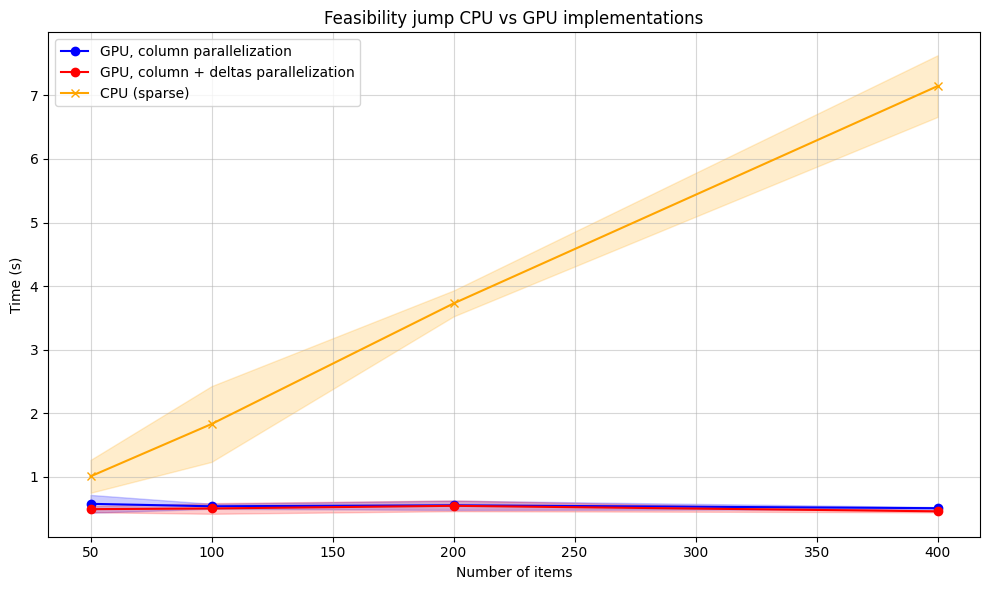

Numba compilation time: 2.09


/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Benchmarking:   0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 9 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 2 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Instance generation time (trial=0, value=200): 0.033540s
Instance generation time (trial=1, value=200): 0.012743s
Instance generation time (trial=2, value=200): 0.012838s
Instance generation time (trial=0, value=400): 0.035610s


/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 17 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 4 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Instance generation time (trial=1, value=400): 0.027143s
Instance generation time (trial=2, value=400): 0.093194s


/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 18 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Instance generation time (trial=0, value=800): 0.078495s


/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 34 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 7 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Instance generation time (trial=1, value=800): 0.117737s
Instance generation time (trial=2, value=800): 0.074613s


/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 35 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Instance generation time (trial=0, value=1600): 0.300767s


/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 69 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 13 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Instance generation time (trial=1, value=1600): 0.228230s


/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 68 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Instance generation time (trial=2, value=1600): 0.392427s
Instance generation time (trial=0, value=3200): 0.638238s


/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 25 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Instance generation time (trial=1, value=3200): 0.849902s
Instance generation time (trial=2, value=3200): 0.609213s
Instance generation time (trial=0, value=6400): 2.609099s


/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 50 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 26 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Instance generation time (trial=1, value=6400): 2.407744s
Instance generation time (trial=2, value=6400): 2.836037s


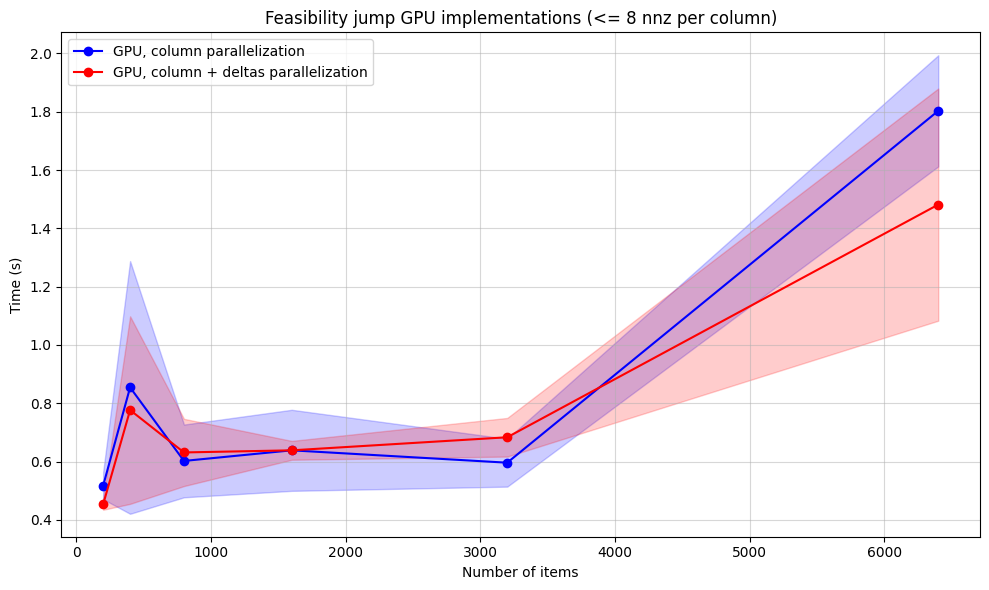

Numba compilation time: 1.72


/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Benchmarking:   0%|          | 0/7 [00:00<?, ?it/s]

Instance generation time (trial=0, value=10): 0.805013s


/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 25 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 13 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Instance generation time (trial=1, value=10): 1.196752s
Instance generation time (trial=2, value=10): 0.705025s
Instance generation time (trial=0, value=20): 0.724502s
Instance generation time (trial=1, value=20): 0.725227s
Instance generation time (trial=2, value=20): 0.859054s
Instance generation time (trial=0, value=40): 1.355600s
Instance generation time (trial=1, value=40): 1.106564s
Instance generation time (trial=2, value=40): 0.690084s
Instance generation time (trial=0, value=80): 0.718069s
Instance generation time (trial=1, value=80): 0.871931s
Instance generation time (trial=2, value=80): 0.880889s
Instance generation time (trial=0, value=160): 1.199372s
Instance generation time (trial=1, value=160): 0.741198s
Instance generation time (trial=2, value=160): 0.710855s
Instance generation time (trial=0, value=320): 0.775005s
Instance generation time (trial=1, value=320): 0.729705s
Instance generation time (trial=2, value=320): 0.743113s
Instance generation time (trial=0, value=6

/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 2 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Instance generation time (trial=1, value=640): 1.073400s
Instance generation time (trial=2, value=640): 1.051639s


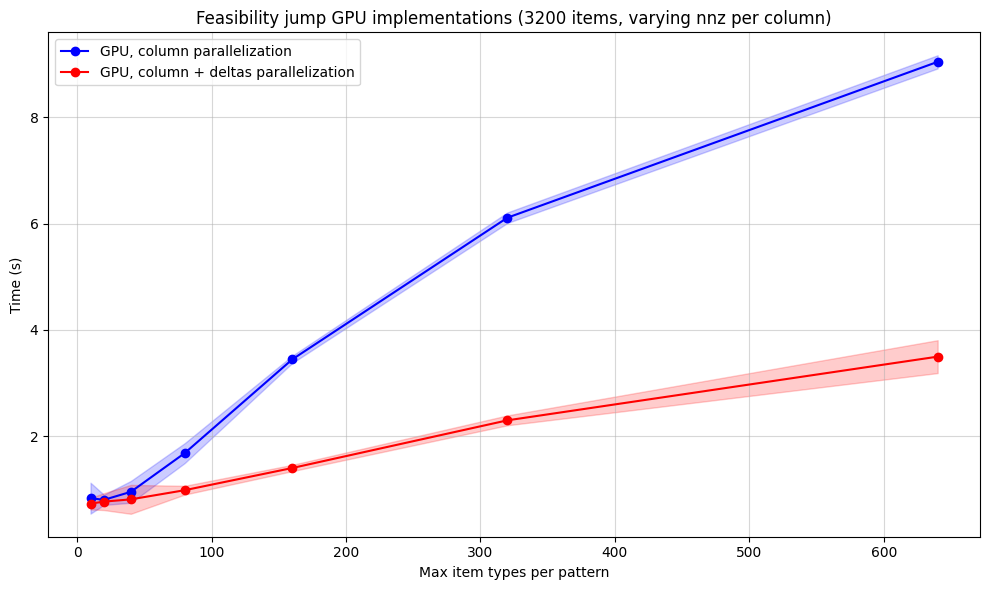

In [14]:
import gc
import time
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm


def benchmark_execution(func, force_recompile=False, *args, **kwargs):
  """Runs a function for benchmarking."""
  start_time = time.perf_counter()
  if force_recompile:
    recompile_numba_functions()
  solution = func(*args, **kwargs)
  end_time = time.perf_counter()
  return end_time - start_time, solution


def recompile_numba_functions():
  compute_critical_deltas_gpu_numba.recompile()
  compute_best_deltas_and_scores_gpu_numba_v1.recompile()
  compute_best_deltas_and_scores_gpu_numba_v2.recompile()
  update_residuals_gpu_numba.recompile()
  update_weights_and_check_feasibility_gpu_numba.recompile()
  compute_delta_bounds_gpu_numba.recompile()


def run_benchmark(
    mode: str,
    values_to_test: list,
    fixed_param: int,
    num_trials: int = 3,
    max_steps: int = 200,
    num_extra_patterns_ratio: float = 1.0,
    max_bin_width: int = 400,
    seed_offset: int = 1234,
    run_cpu: bool = True,
    force_recompile: bool = True,
):
  results = {
      'mode': mode,
      'values': values_to_test,
      'gpu_v1_mean': [],
      'gpu_v1_std': [],
      'gpu_v2_mean': [],
      'gpu_v2_std': [],
      'cpu_mean': [],
      'cpu_std': [],
  }

  if not force_recompile:
    warmup_instance = generate_cutting_stock_instance(
        num_items=10,
        num_extra_patterns=10,
        max_item_types_per_pattern=10,
        seed=0,
    )
    init_x = initialize_solution(warmup_instance)
    start_time = time.perf_counter()
    recompile_numba_functions()
    run_feasibility_jump_gpu_numba(
        instance=warmup_instance,
        init_x=init_x.copy(),
        max_num_steps=10,
        use_v2_parallelization=False,
        print_progress=False,
    )
    end_time = time.perf_counter()
    print(f"Numba compilation time: {end_time - start_time:.2f}")

  for val in tqdm(values_to_test, desc='Benchmarking'):

    if mode == 'size':
      n_items = val
      max_types = min(fixed_param, n_items)
    elif mode == 'density':
      n_items = fixed_param
      max_types = min(val, n_items)
    else:
      raise ValueError("mode must be 'size' or 'density'")

    n_patterns = int(n_items * num_extra_patterns_ratio)

    gpu_v1_times = []
    gpu_v2_times = []
    cpu_times = []

    for i in range(num_trials):
      seed = seed_offset + (val * 100) + i

      start_time = time.perf_counter()
      instance = generate_cutting_stock_instance(
          num_items=n_items,
          num_extra_patterns=n_patterns,
          max_item_types_per_pattern=max_types,
          max_bin_width=max_bin_width,
          seed=seed,
      )
      end_time = time.perf_counter()
      print(f"Instance generation time (trial={i}, value={val}): {end_time - start_time:2f}s")

      init_x = initialize_solution(instance)

      t_gpu_v1, solution = benchmark_execution(
          run_feasibility_jump_gpu_numba,
          instance=instance,
          init_x=init_x.copy(),
          max_num_steps=max_steps,
          use_v2_parallelization=False,
          print_progress=False,
          force_recompile=force_recompile,
      )
      gpu_v1_times.append(t_gpu_v1)

      t_gpu_v2, solution = benchmark_execution(
          run_feasibility_jump_gpu_numba,
          instance=instance,
          init_x=init_x.copy(),
          max_num_steps=max_steps,
          use_v2_parallelization=True,
          print_progress=False,
          force_recompile=force_recompile,
      )
      gpu_v2_times.append(t_gpu_v2)

      if run_cpu:
        t_cpu, solution = benchmark_execution(
            run_feasibility_jump_cpu_sparse,
            instance=instance,
            init_x=init_x.copy(),
            max_num_steps=max_steps,
            print_progress=False,
        )
        cpu_times.append(t_cpu)

    results['gpu_v1_mean'].append(np.mean(gpu_v1_times))
    results['gpu_v1_std'].append(np.std(gpu_v1_times))
    results['gpu_v2_mean'].append(np.mean(gpu_v2_times))
    results['gpu_v2_std'].append(np.std(gpu_v2_times))
    if run_cpu:
      results['cpu_mean'].append(np.mean(cpu_times))
      results['cpu_std'].append(np.std(cpu_times))

  return results


def plot_benchmark_results(res, title):
  vals = np.array(res['values'])
  mode = res['mode']

  g1_mean = np.array(res['gpu_v1_mean'])
  g1_std = np.array(res['gpu_v1_std'])
  g2_mean = np.array(res['gpu_v2_mean'])
  g2_std = np.array(res['gpu_v2_std'])
  c_mean = np.array(res['cpu_mean'])
  c_std = np.array(res['cpu_std'])

  plt.figure(figsize=(10, 6))

  plt.plot(vals, g1_mean, label='GPU, column parallelization', marker='o', color='blue')
  plt.fill_between(
      vals, g1_mean - g1_std, g1_mean + g1_std, alpha=0.2, color='blue'
  )

  plt.plot(vals, g2_mean, label='GPU, column + deltas parallelization', marker='o', color='red')
  plt.fill_between(
      vals, g2_mean - g2_std, g2_mean + g2_std, alpha=0.2, color='red'
  )

  if c_mean.size != 0:
    plt.plot(vals, c_mean, label='CPU (sparse)', marker='x', color='orange')
    plt.fill_between(
        vals, c_mean - c_std, c_mean + c_std, alpha=0.2, color='orange'
    )

  plt.ylabel('Time (s)')
  plt.title(title)
  if mode == 'size':
    plt.xlabel('Number of items')
  else:
    plt.xlabel('Max item types per pattern')

  plt.legend()
  plt.grid(True, which='both', ls='-', alpha=0.5)
  plt.tight_layout()
  plt.show()


# Run a comparison with the CPU implementation. Keep in mind that the CPU
# implementation could be faster if implemented in a lower-level language.
results_size = run_benchmark(
    mode='size',
    values_to_test=[50, 100, 200, 400],
    fixed_param=8,  # max_item_types_per_pattern
    run_cpu=True,
    force_recompile=False,  # exclude compilation time
)
plot_benchmark_results(
    results_size,
    title='Feasibility jump CPU vs GPU implementations'
)

# Run a comparison between the two parallelization schemes. We also check the
# effect of compilation time. We observe that with a small number of nonzeros,
# the first parallelization scheme is actually faster for larger sizes.
results_size = run_benchmark(
    mode='size',
    values_to_test=[200, 400, 800, 1600, 3200, 6400],
    fixed_param=8,  # max_item_types_per_pattern
    run_cpu=False,
    force_recompile=False,  # exclude compilation time
)
plot_benchmark_results(
    results_size,
    title='Feasibility jump GPU implementations (<= 8 nnz per column)'
)

# We observe that the second parallelization scheme is better when we have more
# nonzeros per column. The x-axis increases the number of items types per
# pattern, increasing the number of nonzeros in a column.
results_density = run_benchmark(
    mode='density',
    values_to_test=[10, 20, 40, 80, 160, 320, 640],
    fixed_param=3200, # num_items
    max_bin_width=5000,  # large bin to allow denser columns
    run_cpu=False,
    force_recompile=False,  # exclude compilation time
)
plot_benchmark_results(
    results_density,
    title='Feasibility jump GPU implementations (3200 items, varying nnz per column)'
)

This concludes Part 2 of the tutorial! Part  3 follows with a JAX implementation on GPU.